In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch import nn
from evaluation_methods import per_image_curvature_with_loss, noise_testing
from resnet_architecture import ResNet18

In [2]:
class AddUniformNoise:
    def __init__(self, epsilon=50/255):
        self.epsilon = epsilon

    def __call__(self, tensor):
        noise = torch.empty_like(tensor).uniform_(-self.epsilon, self.epsilon)
        return torch.clamp(tensor + noise, 0.0, 1.0)  # keep in valid image range
    
class AddGaussianNoise:
    def __init__(self, std=50/255):
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std
        return torch.clamp(tensor + noise, 0.0, 1.0)

In [3]:
data_dir = 'dataset'

test_transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                               (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

test_dataset  = torchvision.datasets.CIFAR10(data_dir, train=False, download=False)
test_dataset.transform = test_transform
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, shuffle=False)

### Computing curvatures for each input (on clean data)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
loss_fn = nn.CrossEntropyLoss()
model = ResNet18(num_classes=10,inter_dim=128).to(device)
model.load_state_dict(torch.load('./saved_models/resnet18_sgd_train_no_200_epochs'))
list_curvature0 = per_image_curvature_with_loss(model, test_loader, loss_fn, h=1e-2)

Using cuda device
Processing batch  0
Processing batch  20
Processing batch  40
Processing batch  60
Processing batch  80
Processing batch  100
Processing batch  120
Processing batch  140


### Computing number of correct predictions over different random noisy corruption (for each input)

In [5]:
data_dir = 'dataset'

test_data_noise  = torchvision.datasets.CIFAR10(data_dir, train=False, download=False)



#### Gaussian

test_transform_noise = transforms.Compose([
                               transforms.ToTensor(),
                               AddGaussianNoise(0.06),
                               transforms.Normalize(
                                (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])
test_data_noise.transform = test_transform_noise
test_loader_noise = torch.utils.data.DataLoader(test_data_noise, batch_size=64, num_workers=2, shuffle=False)

correct_list_gauss = noise_testing(model, len(test_data_noise), test_loader_noise, num_sim=10)


#### Uniform

test_transform_noise = transforms.Compose([
                               transforms.ToTensor(),
                               AddUniformNoise(0.06),
                               transforms.Normalize(
                                (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])
test_data_noise.transform = test_transform_noise
test_loader_noise = torch.utils.data.DataLoader(test_data_noise, batch_size=64, num_workers=2, shuffle=False)

correct_list_uni = noise_testing(model, len(test_data_noise), test_loader_noise, num_sim=10)

print("Done!!!!")

Noise simulation 0
Noise simulation 1
Noise simulation 2
Noise simulation 3
Noise simulation 4
Noise simulation 5
Noise simulation 6
Noise simulation 7
Noise simulation 8
Noise simulation 9
Noise simulation 0
Noise simulation 1
Noise simulation 2
Noise simulation 3
Noise simulation 4
Noise simulation 5
Noise simulation 6
Noise simulation 7
Noise simulation 8
Noise simulation 9
Done!!!!


In [6]:
list_mean_curvature_gauss = []
list_mean_curvature_uni = []
for c in range(1,11):
    
    arg = np.where(correct_list_gauss==c)[0]
    mean_curvature = list_curvature0[arg].mean()   
    list_mean_curvature_gauss += [mean_curvature]
    
    arg = np.where(correct_list_uni==c)[0]
    mean_curvature = list_curvature0[arg].mean()   
    list_mean_curvature_uni += [mean_curvature]
    
list_mean_curvature_gauss = np.array(list_mean_curvature_gauss)
list_mean_curvature_uni = np.array(list_mean_curvature_uni)

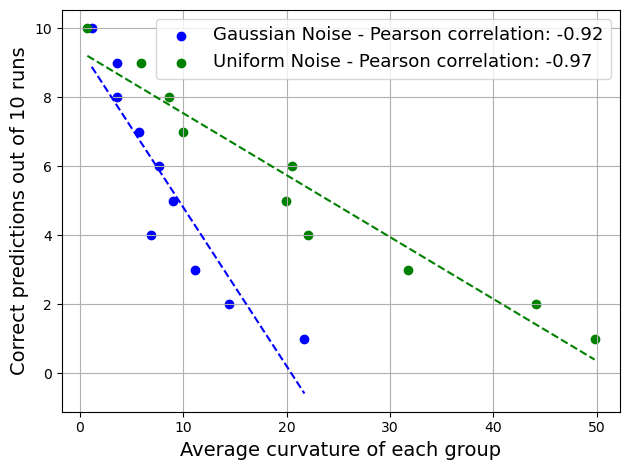

In [7]:
from scipy.stats import pearsonr

r_gauss, _ = pearsonr(list_mean_curvature_gauss, np.arange(1,11))
r_uni, _ = pearsonr(list_mean_curvature_uni, np.arange(1,11))

plt.scatter(list_mean_curvature_gauss, np.arange(1,11), color='blue', label = f'Gaussian Noise - Pearson correlation: {r_gauss:.2f}')
coeffs_gauss = np.polyfit(list_mean_curvature_gauss, np.arange(1,11), 1)  # degree 1 = straight line
line_gauss = np.poly1d(coeffs_gauss)
plt.plot([min(list_mean_curvature_gauss),max(list_mean_curvature_gauss)],\
         [max(line_gauss(list_mean_curvature_gauss)),min(line_gauss(list_mean_curvature_gauss))], color='blue', linestyle='--')


plt.scatter(list_mean_curvature_uni, np.arange(1,11), color='green', label = f'Uniform Noise - Pearson correlation: {r_uni:.2f}')
coeffs_uni = np.polyfit(list_mean_curvature_uni, np.arange(1,11), 1)  # degree 1 = straight line
line_uni = np.poly1d(coeffs_uni)
plt.plot([min(list_mean_curvature_uni),max(list_mean_curvature_uni)],\
         [max(line_uni(list_mean_curvature_uni)),min(line_uni(list_mean_curvature_uni))], color='green', linestyle='--')

plt.xlabel("Average curvature of each group",fontsize=14)
plt.ylabel("Correct predictions out of 10 runs",fontsize=14)

plt.legend(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()